In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import datetime
import random
from statsmodels.stats.power import tt_ind_solve_power

def date_converter(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')

### Задание 3
**Срок сдачи: 07 апреля 18:00**

В этом задание вы будете работать с выручкой - метрикой с достаточно высокой дисперсией и соответсвенно низкой чувствительностью к изменениям.

Вам предстоит разработать подход по повышению чувствительности этой метрики.
От успеха данной инициативы зависит то, как быстро мы сможем проверять продуктовые гипотезы.

#### Для планирования эксперимента изучите данные и метрики 2 балла:

- Загрузите файл и изучите данные;
- Изучите основные статистики метрики: среднее, стандартное отклонение;
- Изучите то, как эти статистики изменяются внутри срезов: user_segment, region, category


#### Описание данныx

event_date - дата 

user_id - идентификатор пользователя

user_segment - сегмент пользователей

region - регион

category - категория авито

revenue_amount - сумма покупок


In [2]:
df = pd.read_csv('user_amount_var_reduction.csv')
df['event_date'] = df.event_date.apply(date_converter)
df.head()

,event_date,user_id,user_segment,category,region,revenue_amount
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160


In [3]:
df.revenue_amount.describe().apply(lambda x: format(x, 'f'))

count    8625842.000000
mean         400.904657
std          960.221741
min            1.000000
25%           88.000000
50%          167.000000
75%          405.000000
max       288123.000000
Name: revenue_amount, dtype: object

Действительно, выручка имеет очень большое СКО

In [83]:
df.groupby(['user_segment']).revenue_amount.describe()

,count,mean,std,min,25%,50%,75%,max
user_segment,,,,,,,,
853431062533847667,1001507.0,1094.330305,2392.330098,1.0,226.0,489.0,1113.0,288123.0
2376074197230840906,4013951.0,401.615956,571.446013,4.0,109.0,209.0,475.0,52540.0
4626944681007198896,3610384.0,207.760172,285.545686,4.0,63.0,112.0,230.0,19950.0


Text(0.5, 1.0, 'user_segment stds')

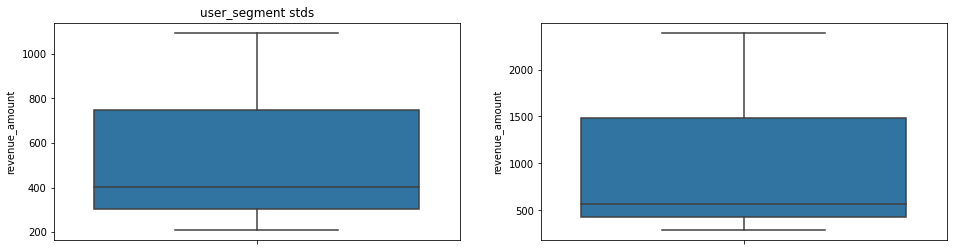

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

sns.boxplot(y=df.groupby(['user_segment']).revenue_amount.mean(), ax=axes[0])
axes[0].set_title('user_segment means')

sns.boxplot(y=df.groupby(['user_segment']).revenue_amount.std(), ax=axes[1])
axes[0].set_title('user_segment stds')

Внутри срезов по user_segment среднее и СКО сильно отличаются

Text(0.5, 1.0, 'category stds')

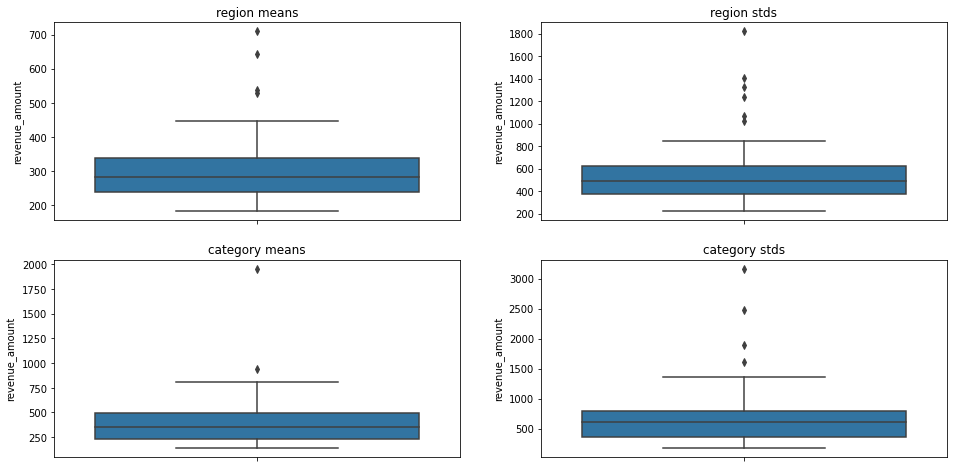

In [18]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

sns.boxplot(y=df.groupby(['region']).revenue_amount.mean(), ax=axes[0, 0])
axes[0, 0].set_title('region means')

sns.boxplot(y=df.groupby(['region']).revenue_amount.std(), ax=axes[0, 1])
axes[0, 1].set_title('region stds')

sns.boxplot(y=df.groupby(['category']).revenue_amount.mean(), ax=axes[1, 0])
axes[1, 0].set_title('category means')

sns.boxplot(y=df.groupby(['category']).revenue_amount.std(), ax=axes[1, 1])
axes[1, 1].set_title('category stds')

Для срезов по region И category разброс среднего и СКО не так велики, как для user_segment. Хотя имеют сильные выбросы, особенно СКО


#### Предскажите минимально детектируемый эффект (MDE) 2 балла:

- Для размеров тестовых групп 10,25,50% и длительностей 30, 60, 90 дней предскажите минимально детектируемый эффект;


In [26]:
def choose_date(data, start_date, delta, share): 
    tmp = data[(data.event_date >= start_date) & (data.event_date <= start_date + datetime.timedelta(days=delta))]
    tmp = tmp.groupby(['user_id']).sum().reset_index()
    x = tmp[(tmp.user_id) % 100 <= 100*share].reset_index()
    return x

На последних трех месяцах

In [23]:
last_3_months = df[df.event_date >= '2019-10-01']

In [30]:
MDEs = []
for i in [30, 60, 90]:
    for j in [1, 2.5, 5]:

        x = choose_date(last_3_months, min(last_3_months.event_date), i, j/10) # получаем необходимую подвыборку

        
        mean = x.revenue_amount.mean()
        std = x.revenue_amount.std()
        alpha = 0.05
        power = 0.8
        
            
        effect_size = tt_ind_solve_power(effect_size=None, alpha=alpha, power=power, nobs1=x.shape[0], ratio=(10 - j)/j, alternative = 'two-sided')    
        MDEs.append([i, j*10, effect_size, effect_size*std])
        print(f'Длительность: {i}, размер {j*10} %, MDE {effect_size*std}, срднее {mean}, std {std}') # 


Длительность: 30, размер 10 %, MDE 246.6019380436979, срднее 1043.7068149977113, std 7473.027851423697
Длительность: 30, размер 25.0 %, MDE 111.44431948243854, срднее 1052.1895276738508, std 8219.810139149788
Длительность: 30, размер 50 %, MDE 54.333645493037274, срднее 1041.6557131027225, std 7931.516637805615
Длительность: 60, размер 10 %, MDE 289.9782057605011, срднее 1269.6505724820493, std 10507.801063628704
Длительность: 60, размер 25.0 %, MDE 124.92573117166624, срднее 1275.438192218087, std 11018.000264954419
Длительность: 60, размер 50 %, MDE 63.537822552455005, срднее 1265.7312709645578, std 11089.09819315966
Длительность: 90, размер 10 %, MDE 297.7185920407089, срднее 1323.8597789267249, std 11255.322328617807
Длительность: 90, размер 25.0 %, MDE 127.34951287693092, срднее 1331.4330499868356, std 11721.488088814554
Длительность: 90, размер 50 %, MDE 64.5545341798482, срднее 1319.885562879818, std 11754.279197783371


In [31]:
min(MDEs, key=lambda x: x[3])

[30, 50, 0.006850347540602219, 54.333645493037274]

При длительности 30 дней и размере 50 %, MDE минимален и равен 54.3, а стандартизированный MDE равен 0.007.

С начала

In [36]:
MDEs = []
for i in [30, 60, 90]:
    for j in [1, 2.5, 5]:

        x = choose_date(df, min(df.event_date), i, j/10) # получаем необходимую подвыборку

        
        mean = x.revenue_amount.mean()
        std = x.revenue_amount.std()
        alpha = 0.05
        power = 0.8
        
            
        effect_size = tt_ind_solve_power(effect_size=None, alpha=alpha, power=power, nobs1=x.shape[0], ratio=(10 - j)/j, alternative = 'two-sided')    
        MDEs.append([i, j*10, effect_size, effect_size*std])
        print(f'Длительность: {i}, размер {j*10} %, MDE {effect_size*std}, срднее {mean}, std {std}') # 


Длительность: 30, размер 10 %, MDE 78.25114665544338, срднее 1001.790907217102, std 6905.511883034233
Длительность: 30, размер 25.0 %, MDE 62.86846578021405, срднее 1008.828878636757, std 7786.768516769544
Длительность: 30, размер 50 %, MDE 47.711619824364014, срднее 987.4865786393725, std 6761.943172332728
Длительность: 60, размер 10 %, MDE 98.20289936394644, срднее 1272.554426483381, std 10755.404117691782
Длительность: 60, размер 25.0 %, MDE 77.56387447726031, срднее 1286.3497134027207, std 11925.022317828407
Длительность: 60, размер 50 %, MDE 59.16372756008988, срднее 1262.971132384613, std 10401.374205355281
Длительность: 90, размер 10 %, MDE 108.84317480867584, срднее 1451.1763804688012, std 13643.824287517415
Длительность: 90, размер 25.0 %, MDE 88.54951036954296, срднее 1471.5001281176583, std 15578.256968553891
Длительность: 90, размер 50 %, MDE 67.88001407256384, срднее 1447.4503260953327, std 13660.898582165919


In [38]:
min(MDEs, key=lambda x: x[3])

[30, 50, 0.007055903696378524, 47.711619824364014]

При длительности 30 дней и размере 50 %, MDE минимален и равен 47.7, а стандартизированный MDE равен 0.007.



#### CUPED 6 баллов
Разработайте подход по снижению дисперсии на основе методики CUPED:

- Рассчитайте CUPED метрику на основе данных за периода в 30 дней перед предполагаемым периодом сбора основной выборки и опишите как изменился MDE для выборок 50/50%, собранных за 30 дней (2 бала). 
- Проверьте насколько данный подход подвержен сезональности. Как меняется MDE, если применять данный подход в разные периоды (2 бала). 
- Оптимизируйте подход варьируя количество дней до теста, которые вы будете для расчёта CUPED метрики. Какое максимальное снижение MDE вы смогли достичь (2 бала).


In [39]:
def cuped_mde_compute(data_frame: pd.DataFrame, start: std, days_before_test: int=30) -> float:
    """
        Расчет CUPED метрики на основе данных за период в days_before_test дней перед 
        предполагаемым периодом сбора основной выборки и  MDE для выборок 50/50%, собранных за 30 дней.
        
        data_frame: columns = ['user_id', 'revenue_amount']
    """
    end = datetime.datetime.strptime(start, '%Y-%m-%d') - datetime.timedelta(days=1)
    pre_data = data_frame[(data_frame.event_date >= end - datetime.timedelta(days=days_before_test)) & 
                  (data_frame.event_date <= end)]
    pre_data = pre_data.groupby(['user_id']).sum().reset_index()[['user_id', 'revenue_amount']]
    pre_data.rename(columns={'revenue_amount': 'pre_revenue_amount'}, inplace=True)
    pre_data['group'] = np.where((pre_data.user_id) % 100 <= 100*0.5, 'test', 'control')


    data = data_frame[(data_frame.event_date >= datetime.datetime.strptime(start, '%Y-%m-%d')) & 
                (data_frame.event_date <= datetime.datetime.strptime(start, '%Y-%m-%d') + datetime.timedelta(days=30))]
    data = data.groupby(['user_id']).sum().reset_index()[['user_id', 'revenue_amount']]
    data['group'] = np.where((data.user_id) % 100 <= 100*0.5, 'test', 'control')


    full_data = data.merge(pre_data, on='user_id', how='left')
    full_data.pre_revenue_amount.fillna(0, inplace=True)
    full_data.group_y.fillna(full_data.group_x, inplace=True)
    full_data.rename(columns={'group_x': 'group'}, inplace=True)
    full_data.drop(columns=['group_y'], inplace=True)


    full_data['pre_revenue_amount_average'] = full_data.pre_revenue_amount.mean()
    teta = np.cov(full_data.revenue_amount, full_data.pre_revenue_amount, ddof=1)[1,0] / np.var(full_data.pre_revenue_amount, ddof=1)
    print(f'theta = {teta}')
    corr = np.corrcoef(full_data.revenue_amount, full_data.pre_revenue_amount)[1,0]
    print(f'corr = {corr}')
    full_data['cuped_revenue_amount'] = full_data.revenue_amount - teta * (full_data.pre_revenue_amount - full_data.pre_revenue_amount_average)
    
    std_total = (full_data.groupby(['group'])['revenue_amount'].var(ddof=1)[0] / 50 + full_data.groupby(['group'])['revenue_amount'].var(ddof=1)[1] / 50)**0.5
    print(f'STD total = {std_total}')
    std_cuped = std_total*(1 - corr**2)**0.5
    print(f'theoretic STD cuped = {std_cuped}')

    data_std_cuped = (full_data.groupby(['group'])['cuped_revenue_amount'].var(ddof=1)[0] / 50 + full_data.groupby(['group'])['cuped_revenue_amount'].var(ddof=1)[1] / 50)**0.5
    print(f'data STD cuped = {data_std_cuped}')
    x = full_data[full_data.group == 'test']

            
    mean = x.cuped_revenue_amount.mean()
    std = x.cuped_revenue_amount.std()
    alpha = 0.05
    power = 0.8

        
    effect_size = tt_ind_solve_power(effect_size=None, alpha=alpha, power=power, nobs1=x.shape[0], ratio=1, alternative = 'two-sided')    
    mde = effect_size*std
    print(f'MDE {mde}, срднее {mean}, std {std}') #



    return mde

Для периода, на котором получили MDE - 54.3

In [44]:
cuped_mde_compute(df, '2019-10-01')

theta = 1.1036949218056955
corr = 0.8923722868345921
STD total = 1565.2287399379009
theoretic STD cuped = 706.3877506053001
data STD cuped = 707.8571445445777
MDE 22.06005577617632, срднее 1046.2346395361344, std 3220.2827149171185


22.06005577617632

In [46]:
7931.51/3220.3

2.462972393876347

Видим сильное уменьшение MDE с 54.3 до 22, а именно в 2.5 раза.

In [47]:
seasonal_mde = []
starts = [datetime.datetime.strptime('2019-06-18', '%Y-%m-%d') + datetime.timedelta(days=31)]
while starts[-1] <= df.event_date.iloc[-1] - datetime.timedelta(days=30):
    starts.append(starts[-1] + datetime.timedelta(days=30))
starts.pop(-1)
for start in starts:
    print(f'Время начала: {start}\n')
    seasonal_mde.append((str(start)[:10], cuped_mde_compute(df, str(start)[:10])))
    print()

Время начала: 2019-07-19 00:00:00

theta = 0.8684844801253909
corr = 0.8525084500889035
STD total = 1252.4260115193808
theoretic STD cuped = 654.6599114269022
data STD cuped = 653.1899387488452
MDE 28.284214649603413, срднее 1006.9553386939523, std 3941.1968508987306

Время начала: 2019-08-18 00:00:00

theta = 0.9426932222768987
corr = 0.9081462232226486
STD total = 1298.983108437214
theoretic STD cuped = 543.8233348368967
data STD cuped = 544.5535080922651
MDE 19.82235845659888, срднее 1020.255621179663, std 2800.8480353672876

Время начала: 2019-09-17 00:00:00

theta = 1.0579186515214427
corr = 0.8830726123783919
STD total = 1494.8813638015665
theoretic STD cuped = 701.4526893379108
data STD cuped = 703.9379987826109
MDE 20.122826922741055, срднее 1038.704643155219, std 2916.634607388478

Время начала: 2019-10-17 00:00:00

theta = 0.7773354093128058
corr = 0.873023742070727
STD total = 1403.5784074559112
theoretic STD cuped = 684.4938991644367
data STD cuped = 684.9476293867154
MDE 2

In [97]:
days_before_test_list = [5, 10, 15, 20, 25, 30]
seasonal_mde_by_days_before = []
for days_before_test in days_before_test_list:
    starts = [datetime.datetime.strptime('2019-06-18', '%Y-%m-%d') + datetime.timedelta(days=days_before_test + 1)]
    while starts[-1] <= df.event_date.iloc[-1] - datetime.timedelta(days=30):
        starts.append(starts[-1] + datetime.timedelta(days=30))
    starts.pop(-1)
    for start in starts:
        print(f'Время начала: {start}\n')
        seasonal_mde_by_days_before.append((days_before_test, str(start)[:10], cuped_mde_compute(df, str(start)[:10], days_before_test)))
        print()

Время начала: 2019-06-24 00:00:00

theta = 4.5127045116148805
corr = 0.7888967435102445
STD total = 1260.9240507294014
theoretic STD cuped = 774.8703294286387
data STD cuped = 775.182905836938
MDE 30.03039680059749, срднее 1007.8998690467417, std 4260.702748878155

Время начала: 2019-07-24 00:00:00

theta = 3.613606775677062
corr = 0.7491451487792744
STD total = 1326.7168850966987
theoretic STD cuped = 878.8250619797802
data STD cuped = 880.9343554719698
MDE 31.38491710924178, срднее 1037.19428562027, std 4382.244516044375

Время начала: 2019-08-23 00:00:00

theta = 3.816514894442752
corr = 0.851777458591204
STD total = 1277.1791617944425
theoretic STD cuped = 669.1189788238063
data STD cuped = 670.2616488775219
MDE 23.57996667910941, срднее 995.755855536526, std 3340.802796120728

Время начала: 2019-09-22 00:00:00

theta = 4.174582502126489
corr = 0.8577424127006997
STD total = 1506.7754341292489
theoretic STD cuped = 774.6026858632615
data STD cuped = 776.3693649886908
MDE 24.1867180

Проверим на сезональность

In [67]:
seasonal_mde

[('2019-07-19', 28.284214649603413),
 ('2019-08-18', 19.82235845659888),
 ('2019-09-17', 20.122826922741055),
 ('2019-10-17', 24.564428913537796)]

Видно снижение MDE к августу-сентябрю и рост после

Попробуем брать разное кол-во дней для расчета cuped

In [98]:
seasonal_mde_by_days_before_df = pd.DataFrame(seasonal_mde_by_days_before, columns=['days_before', 'start_date', 'mde'])

In [99]:
seasonal_mde_by_days_before_df.head()

,days_before,start_date,mde
0,5,2019-06-24,30.030397
1,5,2019-07-24,31.384917
2,5,2019-08-23,23.579967
3,5,2019-09-22,24.186718
4,5,2019-10-22,26.525822


In [100]:
seasonal_mde_by_days_before_df.groupby('days_before').min().mde

days_before
5     23.579967
10    22.733640
15    21.527998
20    22.762208
25    20.871314
30    19.822358
Name: mde, dtype: float64

Минимальный MDE достигается при 30 днях до теста в августе и равен 19.8

In [120]:
base_mde = []
for start_date in seasonal_mde_by_days_before_df.start_date:
    x = choose_date(df, datetime.datetime.strptime(start_date, '%Y-%m-%d'), 30, 0.5)

            
    mean = x.revenue_amount.mean()
    std = x.revenue_amount.std()
    alpha = 0.05
    power = 0.8

        
    effect_size = tt_ind_solve_power(effect_size=None, alpha=alpha, power=power, nobs1=x.shape[0], ratio=1, alternative = 'two-sided')    
    base_mde.append(effect_size*std)

In [121]:
seasonal_mde_by_days_before_df['base_mde'] = base_mde
seasonal_mde_by_days_before_df['mde_ratio'] = seasonal_mde_by_days_before_df.base_mde / seasonal_mde_by_days_before_df.mde
seasonal_mde_by_days_before_df

,days_before,start_date,mde,base_mde,mde_ratio
0,5,2019-06-24,30.030397,49.698354,1.654935
1,5,2019-07-24,31.384917,52.780123,1.681703
2,5,2019-08-23,23.579967,48.513177,2.057390
3,5,2019-09-22,24.186718,53.166510,2.198170
4,5,2019-10-22,26.525822,51.541717,1.943077
5,10,2019-06-29,31.148355,45.682090,1.466597
6,10,2019-07-29,28.496599,54.156024,1.900438
7,10,2019-08-28,22.733640,49.459065,2.175589
8,10,2019-09-27,23.464819,52.814059,2.250776
9,10,2019-10-27,26.030107,49.251743,1.892107


In [122]:
seasonal_mde_by_days_before_df.groupby('days_before').max().mde_ratio

days_before
5     2.198170
10    2.250776
15    2.323695
20    2.163689
25    2.509503
30    2.618996
Name: mde_ratio, dtype: float64

Наибольшее уменьшение получилось на 30 днях до теста в сентябре, а имеено в 2.62 раза




#### * Стратификация 4 балла (задание для получения дополнительных баллов)
Разработайте подход по снижению дисперсии на основе методики стратификации выборок:

- Стратифицируйте выборки внутри срезов user_segment, region, category
- Рассчитайте стратифицированные среднее,стандартное отклонение для этих выборок и MDE для теста 50/50% длительностью 30 дней.
- В каких срезах достигается наибольшее снижение MDE?



Стратифицируем выборки

In [104]:
strata_df = df.copy()

user_segment_strata_p = df[['user_segment','revenue_amount']].groupby(['user_segment']).count() / df.count()[0]
strata_df = strata_df.join(user_segment_strata_p, on='user_segment', rsuffix='_user_segment_probality')

category_strata_p = df[['category','revenue_amount']].groupby(['category']).count() / df.count()[0]
strata_df = strata_df.join(category_strata_p, on='category', rsuffix='_category_probality')

region_strata_p = df[['region','revenue_amount']].groupby(['region']).count() / df.count()[0]
strata_df = strata_df.join(region_strata_p, on='region', rsuffix='_region_probality')

strata_df.head()

,event_date,user_id,user_segment,category,region,revenue_amount,revenue_amount_user_segment_probality,revenue_amount_category_probality,revenue_amount_region_probality
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139,0.418554,0.085387,0.007404
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193,0.418554,0.079979,0.026311
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160,0.418554,0.055670,0.026311
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209,0.418554,0.012282,0.006319
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160,0.465340,0.088939,0.081648


In [105]:
user_segment_strata_p

,revenue_amount
user_segment,
853431062533847667,0.116105
2376074197230840906,0.465340
4626944681007198896,0.418554


In [106]:
category_strata_p.head()

,revenue_amount
category,
57514010642945023,0.079979
91460430793700892,0.032520
174490086998335078,0.044031
264558924403680107,0.014157
282115902545472456,0.004864


In [107]:
region_strata_p.head()

,revenue_amount
region,
68475388295793322,0.011118
181387893390186210,0.004725
308194675497345788,0.002590
385667469633138042,0.006896
405364780634206711,0.000121


In [108]:
strata_df.head()

,event_date,user_id,user_segment,category,region,revenue_amount,revenue_amount_user_segment_probality,revenue_amount_category_probality,revenue_amount_region_probality
0,2019-06-18,4129257975403696,4626944681007198896,7204754148424990691,2201388710798473628,139,0.418554,0.085387,0.007404
1,2019-06-18,7225254357470025,4626944681007198896,57514010642945023,3048517866726460689,193,0.418554,0.079979,0.026311
2,2019-06-18,8912846500600569,4626944681007198896,5983323600580891431,3048517866726460689,160,0.418554,0.055670,0.026311
3,2019-06-18,20910801279823046,4626944681007198896,6847326422676498281,7762196236856042106,209,0.418554,0.012282,0.006319
4,2019-06-18,34873300821657220,2376074197230840906,3187769798308634693,3855810523611026650,160,0.465340,0.088939,0.081648


In [109]:
strata_df.revenue_amount.mean()

400.9046571917269

In [110]:
def get_strat_mean(strata_df: pd.DataFrame, strat_name: str) -> float:
    return (strata_df.groupby([strat_name]).mean().revenue_amount * strata_df.groupby([strat_name]).mean()[f'revenue_amount_{strat_name}_probality']).sum()


def get_strat_std(strata_df: pd.DataFrame, strat_name: str) -> float:
    return ((strata_df.groupby([strat_name]).var().revenue_amount * strata_df.groupby([strat_name]).mean()[f'revenue_amount_{strat_name}_probality']).sum() / strata_df.count()[0])**0.5
    

In [111]:
get_strat_mean(strata_df, 'user_segment')

400.9046571917269

In [112]:
get_strat_mean(strata_df, 'category')

400.90465719172687

In [113]:
get_strat_mean(strata_df, 'region')

400.904657191727

Вычислим СКО среднего выборки и среднего стратифицированных выборок

In [114]:
(strata_df.revenue_amount.var() / strata_df.count()[0])**0.5

0.326942053194587

In [115]:
get_strat_std(strata_df, 'user_segment')

0.3140204036144855

In [116]:
get_strat_std(strata_df, 'category')

0.3206618426638745

In [117]:
get_strat_std(strata_df, 'region')

0.3229764703528736

Уменьшение отклонения не значительное